Notebook to debug the MCS + NLLS approach.

In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib qt

In [2]:
import os
import sys
from pathlib import Path

In [3]:
src_dir = str(Path(os.getcwd()).parent / "src")
sys.path.insert(1, src_dir)
#os.environ["PYTHONPATH"] = src_dir

In [4]:
import data_loader
import calculate_concentr_diffs
from concentr_diffs_pathlength import *
from plotting import *
from mbll_functions import *
from utils import *
from mcs_function import *
from pathlib import Path
import config
import pickle
from ray import tune
import pmcx
import scipy

import matplotlib.pyplot as plt

In [5]:
config.data_dir

PosixPath('/media/leon/T7/IDP')

In [6]:
config.spectra_dir

PosixPath('/media/leon/Storage/Studium/Informatik/Master/3.Semester/IDP/nonlinear-fit/dataset/UCL-NIR-Spectra/spectra')

In [7]:
config.gpuid

1

In [8]:
loader = data_loader.DataLoaderHELICOID(
    config.dataset_dir,
    wavelength_left_cut=520,
    wavelength_right_cut=850,
    num_wavelengths=20
)

delta_A_gt_img = loader.get_attenuation_change("020-01")
A_gt_img = loader.get_attenuation("020-01")

mu_a_matrix_old = loader.absorption_coefs_old(
    use_diff_oxycco=False,
    use_water_and_fat=True
)

mu_a_matrix = loader.absorption_coefs(
    use_diff_oxycco=False,
    use_water_and_fat=True
)

mu_a_matrix_static = data_loader.DataLoader.absorption_coefs(
    loader.wavelengths,
    use_diff_oxycco=False,
    use_water_and_fat=True
)

print(np.allclose(mu_a_matrix, mu_a_matrix_static))
print(np.max(np.abs(mu_a_matrix - mu_a_matrix_static)))

/home/leon/anaconda3/envs/nonlinear-fit/lib/python3.11/site-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


True
0.0


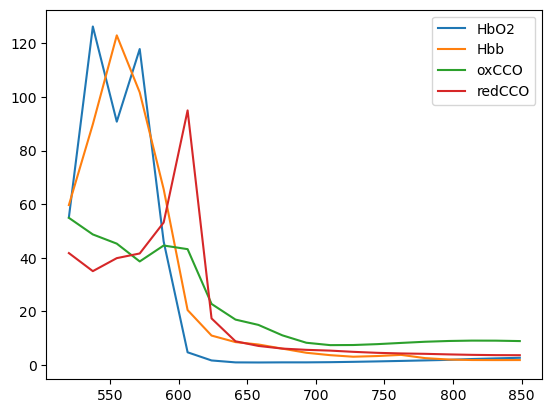

In [9]:
plot_spectra(mu_a_matrix_old[:, :4].T, loader.wavelengths, ["HbO2", "Hbb", "oxCCO", "redCCO", "Water", "Fat"])

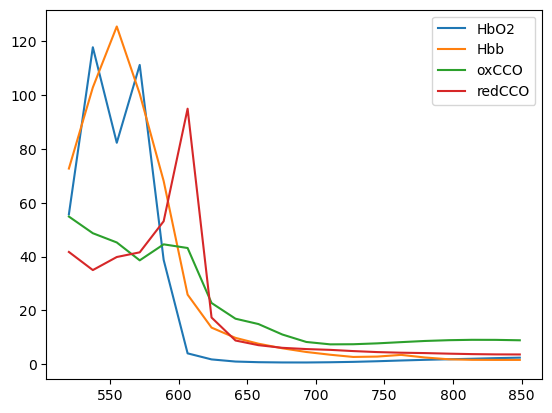

In [10]:
plot_spectra(mu_a_matrix[:, :4].T, loader.wavelengths, ["HbO2", "Hbb", "oxCCO", "redCCO", "Water", "Fat"])

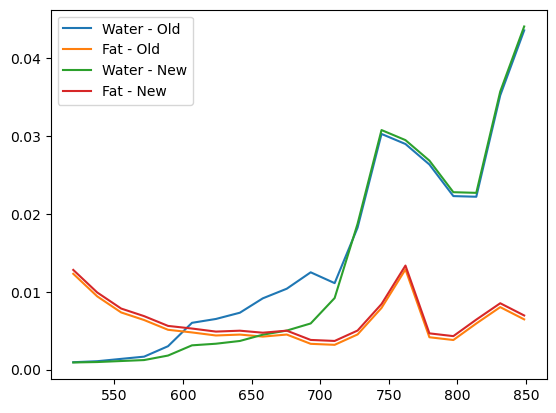

In [11]:
plot_spectra((*(mu_a_matrix_old[:, -2:].T), *(mu_a_matrix[:, -2:].T + 0.0005)), loader.wavelengths, ["Water - Old", "Fat - Old", "Water - New", "Fat - New"])

In [12]:
mu_a_matrix_old[:, -2] / mu_a_matrix[:, -2]

array([2.3025851 , 2.30126438, 2.30221382, 2.30437163, 2.30937602,
       2.29913441, 2.30553602, 2.30155176, 2.29933248, 2.30436851,
       2.30360355, 1.27811221, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ])

In [13]:
loader.wavelengths

array([520.        , 537.45454545, 554.90909091, 571.63636364,
       589.09090909, 606.54545455, 624.        , 641.45454545,
       658.18181818, 675.63636364, 693.09090909, 710.54545455,
       727.27272727, 744.72727273, 762.18181818, 779.63636364,
       797.09090909, 813.81818182, 831.27272727, 848.72727273])

In [14]:
mcs_obj1 = SimulationAttenuation(config.mcs_func_path.parent / "function_data1.npz")
mcs_obj2 = SimulationAttenuation(config.mcs_func_path.parent / "function_data2.npz")

Loaded data with 500000.0 photons and 30 values for mu_s.
Loaded data with 500000.0 photons and 30 values for mu_s.


In [43]:
mcs_obj2.g = 0.8675

Create spectrum with MCS and compare to MCS-func

In [ ]:
#g_combined = 0.8675
g_combined = 0.9
refractive_index_combined = 1.38
vol = np.ones((50, 50, 500))
prop = np.array([[0, 0, 1, 1], [0, 0, g_combined, refractive_index_combined]])
unitinmm = 1

In [16]:
cfg = {
    "nphoton": 5e6, # keep nphotons relatively low, to limit memory of stored data
    "maxdetphoton": 5e6,
    "unitinmm": unitinmm,
    "vol": vol,
    "tstart":0,
    "tend":1e-8,
    "tstep":1e-8,
    "autopilot": 1,
    "gpuid": config.gpuid,
    "prop":prop,
    "bc": "ccrcca001000", # mark z=0 plane as detector
    "srcdir": [0,0,1],
    "srctype": "planar",
    "srcpos": [0, 0, 0],
    "srcparam1": [vol.shape[0], 0, 0, 0], # 3D position of vertex, fourth coordinate is irrelevant
    "srcparam2": [0, vol.shape[1], 0, 0],
    "issrcfrom0": 1,
    "savedetflag": "dps", # detector id, path length, scatter count
    "flog": config.mcs_func_path / "log.txt",
}

In [17]:
mu_a_vals = loader.mu_a_func_gray_matter(loader.wavelengths)
mu_s_vals = loader.mu_s_red_func_gray_matter(loader.wavelengths) / (1-g_combined)

In [18]:
with open(config.result_dir / "A_mcs_generated", "rb") as f:
    A_mcs_generated = pickle.load(f)

In [19]:
skip_simulation = True

In [20]:
if not skip_simulation:
    A_mcs_generated = np.empty((loader.wavelengths.shape[0],))

    for i, wl in enumerate(loader.wavelengths):
        cfg["prop"][1, 0] = mu_a_vals[i] / 10
        cfg["prop"][1, 1] = mu_s_vals[i] / 10
        cfg["prop"][1, 2] = g_combined
        cfg["prop"][1, 3] = refractive_index_combined
        print(f"Iteration {i}/{loader.wavelengths.shape[0]}")
        res = pmcx.mcxlab(cfg)
        weights = pmcx.utils.detweight(res["detp"])
        attenuation = -np.log(np.sum(weights)/cfg["nphoton"])
        A_mcs_generated[i] = attenuation

In [21]:
print(config.result_dir)

/media/leon/T7/IDP/results


In [22]:
with open(config.result_dir / "A_mcs_generated", "wb") as f:
    pickle.dump(A_mcs_generated, f)

In [44]:
A_mcs_func_computed1 = mcs_obj1.A_concentrations(
    loader.wavelengths, 
    mu_a_matrix, 
    loader.params_ref_gray_matter[:6],
    *loader.params_ref_gray_matter[-2:]
)

A_mcs_func_computed2 = mcs_obj2.A_concentrations(
    loader.wavelengths, 
    mu_a_matrix, 
    loader.params_ref_gray_matter[:6],
    *loader.params_ref_gray_matter[-2:]
)

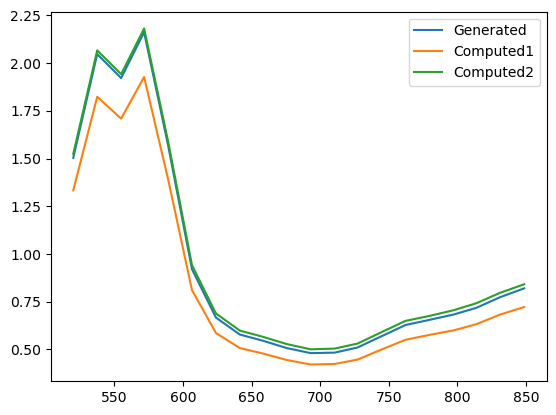

In [45]:
plot_spectra(
    (A_mcs_generated, A_mcs_func_computed1, A_mcs_func_computed2 + 0.02),
    loader.wavelengths,
    labels=["Generated", "Computed1", "Computed2"]
)

In [25]:
A_mcs_generated / A_mcs_func_computed1[:, 0]

array([1.12782599, 1.12252739, 1.12434349, 1.1219275 , 1.1281184 ,
       1.13474267, 1.13795723, 1.13936249, 1.13997533, 1.14054967,
       1.14128323, 1.14007075, 1.14153342, 1.13906624, 1.14048095,
       1.13669651, 1.13831587, 1.13547552, 1.13331618, 1.13520514])

Test fitting with single-thread and without jacobian. See if fitting procedure converges to reference gray matter concentrations, when initialized with slightly perturbed reference concentrations.

In [26]:
init_vals = loader.params_ref_gray_matter + np.array([0.00005, 0.000025, 0.000005, 0.0000025, 0.0005, 0.0015, 0.05, 0.005])
print(init_vals)

[6.4650e-02 1.1425e-02 6.4050e-03 1.6025e-03 7.3050e-01 1.0150e-01
 4.0850e+01 3.0940e+00]


In [27]:
concentrations_to_blood_fraction(init_vals)

array([3.27122500e-02, 8.49819257e-01, 6.40500000e-03, 1.60250000e-03,
       7.30500000e-01, 1.01500000e-01, 4.08500000e+01, 3.09400000e+00])

In [28]:
loader.params_ref_gray_matter_fraction

array([3.268e-02, 8.500e-01, 6.400e-03, 1.600e-03, 7.300e-01, 1.000e-01,
       4.080e+01, 3.089e+00])

In [29]:
params_mcs_flat, errors = concentr_fit_nonlinear(
    A_mcs_generated[:, None],
    loader.wavelengths,
    mu_a_matrix,
    mcs_obj1.A_blood_fraction,
    ref_vals=concentrations_to_blood_fraction(init_vals),
    variables_bool_arr=np.array([True, True, True, True, True, True, True, True]),
    left_bounds=np.array([0, 0, 0, 0, 0, 0, 3, 0.1]),
    right_bounds=np.array([1, 1, 0.01, 0.01, 1, 1, 100, 10]),
    is_delta_A=False,
    progress_bar=False,
)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.5075e-01                                    2.54e+01    
       1              2         5.4436e-04      1.50e-01       5.32e-01       1.15e+00    
       2              3         6.6497e-05      4.78e-04       4.14e-01       1.79e-03    
       3              4         8.5618e-06      5.79e-05       1.98e+00       8.01e-03    
       4              5         3.9171e-06      4.64e-06       4.54e-02       3.85e-05    
       5              6         3.5006e-06      4.16e-07       1.56e-01       3.27e-04    
       6              7         3.1673e-06      3.33e-07       1.49e-01       2.78e-04    
       7              8         2.7500e-06      4.17e-07       4.11e-01       5.84e-03    
       8              9         2.7377e-06      1.23e-08       4.61e-03       1.52e-06    
       9             10         2.7377e-06      3.23e-11       1.06e-03       7.46e-08    

In [30]:
print(params_mcs_flat)

[[4.10846397e-02]
 [8.48042664e-01]
 [7.86767688e-03]
 [2.02873269e-03]
 [9.09410858e-01]
 [1.39803315e-01]
 [3.86945174e+01]
 [3.09002227e+00]]


In [31]:
A_init_reconstr = mcs_obj1.A_concentrations(
    loader.wavelengths,
    mu_a_matrix,
    init_vals[:6],
    *init_vals[-2:]
)

A_reconstr = mcs_obj1.A_blood_fraction(
    loader.wavelengths,
    mu_a_matrix,
    params_mcs_flat[:6, 0],
    *params_mcs_flat[-2:, 0]
)

with open(config.m_params_path, "rb") as f:
    m_params, A_vals, N_vals, dref_vals = pickle.load(f)

A_jacques_reconstr_combinedm = A_jacques_blood_fraction(
    loader.wavelengths,
    mu_a_matrix,
    params_mcs_flat[:6, 0],
    *params_mcs_flat[-2:, 0],
    *m_params[1.38]
)

A_jacques_reconstr_gmm = A_jacques_blood_fraction(
    loader.wavelengths,
    mu_a_matrix,
    params_mcs_flat[:6, 0],
    *params_mcs_flat[-2:, 0],
    *m_params[1.36]
)

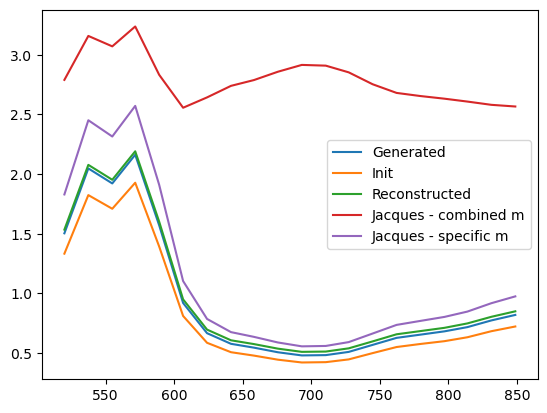

In [32]:
plot_spectra((A_mcs_generated, A_init_reconstr, A_reconstr + 0.03, A_jacques_reconstr_combinedm, A_jacques_reconstr_gmm), loader.wavelengths, ["Generated", "Init", "Reconstructed", "Jacques - combined m", "Jacques - specific m"])

Result: MCS-Func adjusts values so that reconstructed spectrum is essentially identical to input spectrum. If we fit using concentrations, the values are quite different to reference values. Values are much closer to reference/GT concentrations when blood-fraction-model is used. Jacques only produces similar spectrum, if m-parameters for correct tissue type are used.

Compute the jacobian using numeric differentiation, and compare to analytic Jacobian.

In [33]:
eval_vals = loader.params_ref_blood_vessel_fraction #init_vals # loader.params_ref_gray_matter
print(eval_vals)

[9.99320000e-01 7.90017212e-01 0.00000000e+00 0.00000000e+00
 5.50000000e-01 1.00000000e-02 2.20000000e+01 6.60000000e-01]


In [34]:
jac = mcs_obj1.jacobian_blood_fraction(loader.wavelengths, mu_a_matrix, eval_vals[:6], *eval_vals[-2:])

In [35]:
dx = 1e-7
x = np.tile(eval_vals[:, None], (1, 8))
x_dx = x + dx * np.eye(8)
jac_numeric = mcs_obj1.A_blood_fraction(loader.wavelengths, mu_a_matrix, x_dx[:-2,:], *x_dx[-2:, :]) - mcs_obj1.A_blood_fraction(loader.wavelengths, mu_a_matrix, x[:-2, :], *x[-2:, :])
jac_numeric /= dx

In [36]:
print(np.isclose(jac[:, 0, :], jac_numeric))

[[ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True

In [37]:
np.max(np.abs(jac[:, 0, :] - jac_numeric))

9.889785417271924e-07

Test if using the jacobian works and produces the same results.

In [38]:
params_mcs_flat_jacobian, errors = concentr_fit_nonlinear(
    A_mcs_generated[:, None],
    loader.wavelengths,
    mu_a_matrix,
    mcs_obj1.A_concentrations,
    jacobian=mcs_obj1.jacobian_concentrations,
    ref_vals=init_vals,
    variables_bool_arr=np.array([True, True, True, True, True, True, True, True]),
    left_bounds=np.array([0, 0, 0, 0, 0, 0, 3, 0.1]),
    right_bounds=np.array([1, 1, 0.01, 0.01, 1, 1, 100, 10]),
    is_delta_A=False,
    progress_bar=False,
)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.5075e-01                                    1.56e+01    
       1              2         7.2990e-04      1.50e-01       5.82e-01       7.05e-01    
       2              3         7.3448e-05      6.56e-04       4.49e-01       1.08e-03    
       3              4         9.2921e-06      6.42e-05       2.23e+00       8.97e-03    
       4              5         4.0040e-06      5.29e-06       1.69e-01       9.43e-04    
       5              6         3.5732e-06      4.31e-07       2.53e-01       8.90e-04    
       6              7         3.2016e-06      3.72e-07       2.47e-01       2.96e-04    
       7              8         2.7511e-06      4.51e-07       3.98e-01       3.44e-03    
       8             10         2.7427e-06      8.37e-09       4.32e-02       2.59e-05    
       9             11         2.7378e-06      4.94e-09       3.00e-02       5.07e-06    

In [39]:
A_reconstr_jacobian = mcs_obj1.A_concentrations(
    loader.wavelengths,
    mu_a_matrix,
    params_mcs_flat_jacobian[:6, 0],
    *params_mcs_flat_jacobian[-2:, 0]
)

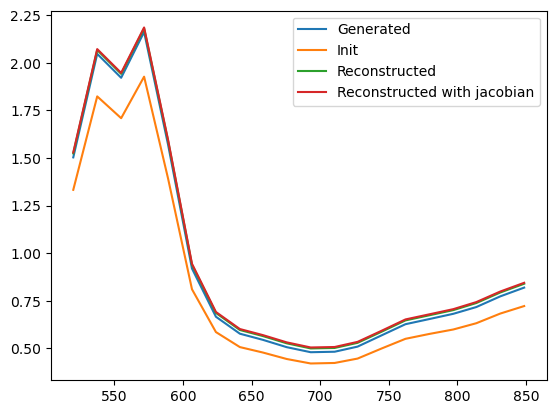

In [40]:
plot_spectra((A_mcs_generated, A_init_reconstr, A_reconstr + 0.02, A_reconstr_jacobian + 0.025), loader.wavelengths, ["Generated", "Init", "Reconstructed", "Reconstructed with jacobian"])

Testing for real spectra.

In [ ]:
test_mask = np.zeros_like(loader.label_map)
test_mask[np.unravel_index(np.random.choice(np.flatnonzero(loader.label_map == 1), size=3, replace=True), labeled_mask.shape)] = True
print(test_mask.shape)

In [ ]:
params_mcs_flat, errors = concentr_fit_nonlinear(
    A_mcs_generated[:, None],
    loader.wavelengths,
    mu_a_matrix,
    mcs_obj1.A_concentrations,
    ref_vals=init_vals,
    variables_bool_arr=np.array([True, True, True, True, True, True, True, True]),
    left_bounds=np.array([0, 0, 0, 0, 0, 0, 3, 0.1]),
    right_bounds=np.array([1, 1, 0.01, 0.01, 1, 1, 100, 10]),
    is_delta_A=False,
    progress_bar=False,
)